In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Decision Trees

Decision trees are quite popular since they are simple to understand and interpret. There are several algorithms to construct them (e.g. [I3](https://en.wikipedia.org/wiki/ID3_algorithm), [C4.5](https://en.wikipedia.org/wiki/C4.5_algorithm)), here we will describe [CART](https://en.wikipedia.org/wiki/Predictive_analytics#Classification_and_regression_trees_.28CART.29) (Classification And Regression Trees).

We will start with regression problems. Our input $x$ consists of $m$ features:

$$
x = \left(
    \begin{matrix} 
    x_1 \\
    \vdots \\
    x_m
    \end{matrix}
    \right)
$$

Note, that unlike in linear- and logistic-regression we don't need the feature $x_0$.
A decision tree will split the feature space into a set of rectangles, like in the figure below.

![title](img/decision_trees_regions.png)

This same model can be represented by a binary tree:

![title](img/decision_trees_binary_tree.png)

The corresponding model can then predict $y$ with a constant $c_p$:

$$
f(x) = \sum_{k=1}^{5}c_p \begin{cases} 
1 & \text{if } x \in R_p \\
0 & \text{if } x \notin R_p
\end{cases}
$$

Or in general, if we have already found $P$ partitions:

$$
f(x) = \sum_{k=1}^{P}c_p \begin{cases} 
1 & \text{if } x \in R_p \\
0 & \text{if } x \notin R_p
\end{cases}
$$

If we use, like in linear regression, the sum of squares ($\sum(y^{(i)} - f(x^{(i)}))^2$) as our criterion for minimization, the best $c_p$ becomes the average of $y^{(i)}$ in region $R_p$:

$$
c_p = \frac{1}{N_p} \sum_{x^{(i)} \in R_p} y^{(i)}
$$

$N_p$ is:

$$
N_p = \#\{x^{(i)} \in R_p\}
$$

To find the best binary partition, characterized by a splitting variable $j$ ($1 \leq j \leq m$) and split point s, define a pair of half planes. Where $x_j < s$:

$$
R_1(j, s) = \{x | x_j < s\}
$$

and $x_j \geq s$:

$$
R_2(j, s) = \{x | x_j \geq s\}
$$

The best splitting variable $j$ and split point $s$ will solve:

$$
\min_{j, s} \Big[\min_{c_1} \sum_{x^{(i)} \in R_1(j, s)} (y^{(i)} - c_1)^2 + \min_{c_2} \sum_{x^{(i)} \in R_2(j, s)} (y^{(i)} - c_2)^2 \Big]
$$

As we have already seen, the inner minimization is solved by taking the average of $y^{(i)}$ in the corresponding region. In order to control overfitting, several techniques exist, here, only `max_depth` of the constructed tree will be used.

In [2]:
class DecisionTreeNode(object):
    
    def __init__(
        self,
        feature_idx=None,
        split_value=None,
        predicted_value=None,
        left=None,
        right=None
    ):
        self.feature_idx = feature_idx
        self.split_value = split_value
        self.predicted_value = predicted_value
        self.left = left
        self.right = right

        
class DecisionTreeRegressor(object):
    
    def __init__(self, max_depth=None):
        self._tree = None
        self._max_depth = max_depth
        
    def predict(self, X):
        def predict_single_row(node, row):
            if node.left is None and node.right is None:
                return node.predicted_value
            if row[node.feature_idx] < node.split_value:
                return predict_single_row(node.left, row)
            else:
                return predict_single_row(node.right, row)
            
        return np.asarray([
            predict_single_row(self._tree, row) for row in X
        ])
    
    def calculate_error(self, y):
        if len(y) == 0:
            return 0
        return 1 / len(y) * np.sum((y - np.mean(y)) ** 2)

    def build_tree(self, X, y, depth=0):
        _, num_features = X.shape
        
        current_error = self.calculate_error(y)

        best_gain = 0
        best_split_feature_idx = None
        best_split_feature_val = None
        best_split_sets = None
        
        for feature_idx in range(num_features):
            for feature_val in set(X[:, feature_idx]):
            
                split_condition = X[:, feature_idx] < feature_val
                X_left_split, X_right_split = X[split_condition], X[~split_condition]
                y_left_split, y_right_split = y[split_condition], y[~split_condition]
            
                left_split_error = self.calculate_error(y_left_split)
                right_split_error = self.calculate_error(y_right_split)
                error_gain = (
                    current_error - len(X_left_split) / len(y) * left_split_error - len(X_right_split) / len(y) * right_split_error
                )
                if error_gain > best_gain and len(X_left_split) > 0 and len(X_right_split) > 0:
                    best_gain = error_gain
                    best_split_feature_idx = feature_idx
                    best_split_feature_val = feature_val
                    best_split_sets = ((X_left_split, y_left_split), (X_right_split, y_right_split))
    
        if best_gain > 0 and (self._max_depth is None or depth < self._max_depth):
            left = self.build_tree(*best_split_sets[0], depth=depth+1)
            right = self.build_tree(*best_split_sets[1], depth=depth+1)
        
            return DecisionTreeNode(
                feature_idx=best_split_feature_idx,
                split_value=best_split_feature_val,
                left=left,
                right=right
            )
    
        else:
            return DecisionTreeNode(
                predicted_value=np.mean(y)
            )
    
    def fit(self, X, y):
        self._tree = self.build_tree(X, y, 0)
        return self

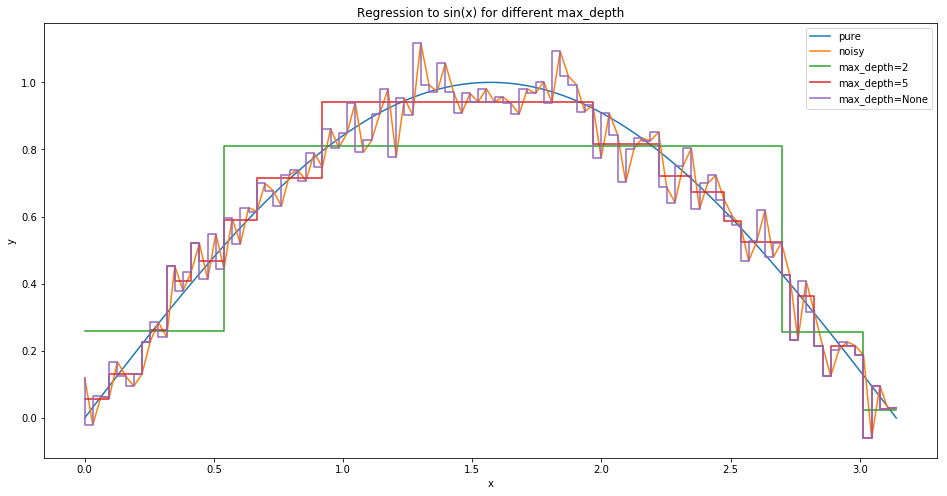

In [3]:
# Demonstration of decision tree regression using different `max_depth` to fit to a sinusoidal function.

X = np.linspace(0, np.pi, 100).reshape(-1, 1)
y_pure = np.sin(X)
y_noisy = y_pure + np.random.normal(0, 0.07, X.shape)


y_predicted = DecisionTreeRegressor(max_depth=3).fit(X, y_noisy).predict(X)

fig, ax = plt.subplots()
ax.plot(X, y_pure, label='pure')
ax.plot(X, y_noisy, label='noisy')

for max_depth in (2, 5, None):
    y_predicted = DecisionTreeRegressor(max_depth=max_depth).fit(X, y_noisy).predict(X)
    ax.step(X, y_predicted, label='max_depth={}'.format(max_depth))

ax.legend()
ax.set(
    xlabel='x',
    ylabel='y',
    title='Regression to sin(x) for different max_depth'
)
fig.set_size_inches(w=16, h=8)